# OISSTv2 Timeseries Preparations

## Goals:

### Load Shapefiles representing three geographic scales:
 - Northeast US Shelf
 - Gulf of Maine, Georges Bank, & Southern New England Regions
 - Inshore Waters of Maine & New Hampshire

### For each:
 - Crop and process timeseries for mean SST and mean sst anomalies
 - Store on Box for further timeseries processing in R

#### Shapefile Sources
 - Northeast Shelf: NOAA NEFSC EPU Shapefiles
 - Gulf of Maine, Georges Bank, & Southern New England Regions: NOAA NEFSC EPU Shapefiles
 - Inshore Waters of Maine & New Hampshire: Maine DMR

Notes on OISSTv2 Data Storage:
OISSTv2 data is downloaded from NOAA's Physical Science Laboratory and stored in GMRI's cloud storage infrastructure for internal use as raw SST, 30-year climatological reference datasets, and sst anomalies. Code documenting that acquisition process can be found at www.github.com/adamkemberling/oisst_mainstays




In [19]:
# Load Libraries
import os
import xarray as xr
import regionmask
import geopandas as gpd
import pandas as pd
import datetime
import numpy as np

### Define Data Access Functions

In [11]:
#-----------------------------------------------------
#
# Set Workspace Path to Box
#
#-----------------------------------------------------
def set_workspace(workspace: str) -> None:
  """
  Switch from local path to docker volume path with a workspace parameter
  
  Args:
    workspace (str): Indication of whether code should be run "local" or whether via "docker"
  
  """
  # Root paths
  # root_locations = {"local"  : "/Users/akemberling/Box/",
  #                   "docker" : "/home/jovyan/"}

  root_locations = {"local"  : "/Users/akemberling/Library/CloudStorage/Box-Box/",
                    "docker" : "/home/jovyan/"}
  
  # Set root with workspace
  box_root = root_locations[workspace]
  
  return box_root


In [12]:
#-----------------------------------------------------
#
# Load OISST from Box
#
#-----------------------------------------------------
def load_box_oisst(box_root, start_yr, end_yr, anomalies = False, do_parallel = False, reference_period = "1982-2011"):
  """
  Load OISST Resources from box using xr.open_mfdataset()
  
  Shorthand to reduce copying this code everywhere.
  """
  
  
  # Set location to OISST data & base file name
  if anomalies == False:
    oisst_location  = f"{box_root}RES_Data/OISST/oisst_mainstays/annual_observations/"
    base_fname      = "sst.day.mean."
    file_ending     = ".v2.nc"
  

  elif anomalies == True:
    climatology_option = {"1991-2020" : "1991to2020", "1991-2020" : "1991to2020"}[reference_period]
    oisst_location = f"{box_root}RES_Data/OISST/oisst_mainstays/annual_anomalies/{climatology_option}_climatology/"
    base_fname     = "daily_anoms_"
    file_ending    = ".nc"
  
  
  # Set start and end years for the update
  start_yr = int(start_yr)
  end_yr   = int(end_yr)
  
  # Load the annual files for oisst
  fpaths = []
  for yr in range(start_yr, end_yr + 1):
      fpaths.append(f'{oisst_location}{base_fname}{yr}{file_ending}')
      
  # Lazy-load using xr.open_mfdataset
  grid_obj = xr.open_mfdataset(fpaths, combine = "by_coords", parallel = do_parallel)
  
  return grid_obj


In [13]:
#-----------------------------------------------------
#
# Load OISST Climatologies
#
#-----------------------------------------------------
def load_oisst_climatology(box_root, reference_period = "1982-2011"):
  """
  Load climatology NetCDF from box 
  
  Args:
    box_root (str): Base location to box from either local path or docker volume
    reference_period (str): start and end year of climatology linked by "-", e.g. "1982-2011"
  
  """
  
  # Set climatology source choices
  climatologies = {"1982-2011" : "daily_clims_1982to2011.nc",
                   "1985-2014" : "daily_clims_1985to2014.nc",
                   "1991-2020" : "daily_clims_1991to2020.nc"}

  # Build file name
  clim_root      = f"{box_root}RES_Data/OISST/oisst_mainstays/daily_climatologies/"
  climate_period = climatologies[reference_period]
  clim_file      = f"{clim_root}{climate_period}"
  
  # Open and return climatology
  oisst_clim = xr.open_dataset(clim_file)
  return oisst_clim

### Load OISST for General Northeast Region

In [14]:
# Load OISST
workspace = "local"
box_root = set_workspace(workspace)

# Set start and end year for climatology
start_year = 1992
end_year = 2022

sst = load_box_oisst(box_root, start_yr = start_year, end_yr = end_year, anomalies = False, do_parallel = True)
clim = load_oisst_climatology(box_root=box_root, reference_period="1991-2020")
#anoms = load_box_oisst(box_root, start_yr = start_year, end_yr = end_year, anomalies = True, do_parallel = True, reference_period = "1991-2020")

# Check it
sst

<xarray.Dataset>
Dimensions:  (time: 11323, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1992-01-02 ... 2022-12-31T12:00:00
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(366, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:40:50 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

### Load Regional Shapefiles
 * All EPU's
 * Inshore Maine and New Hampshire Area

<AxesSubplot:>

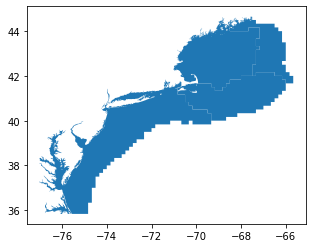

In [15]:
# Load Shapefiles
shapefiles_path = f"{box_root}RES_Data/Shapefiles/EPU/"
epus_poly = gpd.read_file(f"{shapefiles_path}EPU_extended.shp")
gom_poly = gpd.read_file(f"{shapefiles_path}/individual_epus/GOM.geojson")
gb_poly = gpd.read_file(f"{shapefiles_path}/individual_epus/GB.geojson")
mab_poly = gpd.read_file(f"{shapefiles_path}/individual_epus/MAB.geojson")

# Plot check
epus_poly.plot()

### Mask SST and Anomalies Using Shapefiles

In [16]:
#---------------------------------------------------
#
# Get Area Weighted Mean
#
#----------------------------------------------------
def area_weighted_means(grid_obj, var_name = "sst", sd = False):
    """
    Run an area-weighted average using an xarray dataset, the cell weights, and the variable of interest.
    
    Area of the cells is based on latitude and assumes a rectangular grid in lat/lon converting to km
    
    Args:
        grid_obj     : xr.Dataset to calculate average of
        var_name     : data variable
        sd           : perform standard deviations?
    
    
    
    """
    
    # Pull an array of the variable of interest
    array_var = getattr(grid_obj, var_name)
    
    
    #  # From Julius Busecke
    #  delta_lon = np.cos(array_var.lat * np.pi / 180) * 111e3
    #  delta_lat = xr.ones_like(array_var.lon) * 111e3
    #  cell_areas = delta_lon * delta_lat
    
    # From Source: xarray docs
    # http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html
    cell_areas = np.cos(np.deg2rad(array_var.lat))
    cell_areas.name = "weights"
    
    # weight the array with the areas
    grid_weighted = array_var.weighted(cell_areas)
    
    # Get the mean
    if sd == False:
        # print("Processing Area-Weighted Means")
        weighted_vals = grid_weighted.mean(("lat", "lon"))
        weighted_vals = weighted_vals.to_dataset(name = f"area_wtd_{var_name}")
    
#     # Standard deviation not a method available to weighted dataset
#     elif sd == True:
#         # print("Processing Area-Weighted Standard Deviations")
#         weighted_vals = grid_weighted.std(("lat", "lon"))
#         weighted_vals = weighted_vals.to_dataset(name = f"{var_name}_sd")
    
    return weighted_vals

In [17]:
#---------------------------------------------------
#
# Masked Timseries from xr.Dataset
#
#----------------------------------------------------
def calc_ts_mask(grid_obj, shp_obj, shp_name, var_name = "sst", climatology = False):
  """
  Return a timeseries using data that falls within shapefile. 
  
  Standard deviation
  not included so that this function can be used for any period of time.
  
  Args:
    grid_obj       : xr.Dataset of the desired input data to mask
    shp_obj        : shapefile polygon to use as a mask
    shp_name (str) : String to use as name when making mask
    var_name (str) : Optional string identifying the variable to use
    climatology (bool): Whether you are masking a climatology, informs naming conventions and
    whether to process standard deviation
  """

  #### 1. Make the mask
  area_mask = regionmask.Regions(shp_obj.geometry,
                                 name = shp_name)

  #### 2. Mask the array with gom_mask to get nan test
  mask = area_mask.mask(grid_obj, lon_name = "lon", lat_name = "lat")

  
  #### 3. Extract data that falls within the mask
  masked_ds = grid_obj.where(~np.isnan(mask))

  
  #### 4. Calculate timeseries mean

  # Get the timeseries mean of the desired variable
  if climatology == False:
        
    # area-weighted
    masked_ts = area_weighted_means(masked_ds, var_name, sd = False)
    
    # Not area-weighted
    masked_ts[var_name] = getattr(masked_ds, var_name).mean(dim = ("lat", "lon"))
    
   
    
  elif climatology == True:
    
    # area-weighted?
    masked_ts = area_weighted_means(masked_ds, var_name, sd = False)
    # masked_ts["clim_sd"] = area_weighted_means(masked_ds, var_name, sd = True)
    
    # Not area-weighted
    masked_ts[var_name] = getattr(masked_ds, var_name).mean(dim = ("lat", "lon"))
    masked_ts["clim_sd"] = getattr(masked_ds, var_name).std(dim = ("lat", "lon"))
    
    
  
  #### 5. Change time index rownames to a column 

  # Convert to Timeseries Dataframe
  masked_ts_df = masked_ts.to_dataframe()

  # Reset the index, rename variables
  if climatology == False:
    masked_ts_df = masked_ts_df.reset_index()[["time", f"area_wtd_{var_name}", var_name]]
    
  elif climatology == True:
    clim_name = f"{var_name}_clim"
    masked_ts_df = masked_ts_df.reset_index()[["modified_ordinal_day", f"area_wtd_{var_name}", var_name, "clim_sd"]]
    masked_ts_df = masked_ts_df.rename(columns = {f"{var_name}" : f"{clim_name}", f"area_wtd_{var_name}" : "area_wtd_clim"})
  
  # Return the table as output
  return masked_ts_df

### Process timeseries - Single Area Test

In [20]:
# Calculate the weightedd means for the area
shelf_sst = calc_ts_mask(
    grid_obj = sst, 
    shp_obj = epus_poly, 
    shp_name = "Northeast Shelf", 
    var_name = "sst", 
    climatology = False)


/Users/akemberling/opt/anaconda3/envs/py3oisst/lib/python3.8/site-packages/regionmask/core/regions.py:410: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:


In [29]:
# Add MOD to merge with climatology

#-----------------------------------------------------
#
# Add Modified Ordinal Day to pd.DataFrame that has time column
#
#-----------------------------------------------------
def add_mod_to_ts(new_ts):
    """
    Add modified ordinaly day column to pd.DataFrame from time column
    
    Args:
        new_ts : timeseries dataframe that contains "time" datetime64 column.
    
    """
    # Add modified ordinal day, for day-to-day calculation and leapyear adjustment
    not_leap_year  = ~new_ts.time.dt.is_leap_year
    march_or_later =  new_ts.time.dt.month >= 3
    ordinal_day    =  new_ts.time.dt.dayofyear
    mod            =  ordinal_day + (not_leap_year & march_or_later)
    new_ts["modified_ordinal_day"] = mod
    return new_ts



In [30]:
# Inspect it
shelf_sst = add_mod_to_ts(shelf_sst)
shelf_sst.head()

,time,area_wtd_sst,sst,modified_ordinal_day
0,1992-01-01,7.825357,7.777143,1
1,1992-01-02,7.705210,7.654478,2
2,1992-01-03,7.615076,7.563199,3
3,1992-01-04,7.573662,7.523859,4
4,1992-01-05,7.388701,7.345010,5


In [25]:
# Calculate climatological average
shelf_clim = calc_ts_mask(
    grid_obj = clim, 
    shp_obj = epus_poly, 
    shp_name = "Northeast Shelf", 
    var_name = "sst", 
    climatology = True)
shelf_clim.head()

/Users/akemberling/opt/anaconda3/envs/py3oisst/lib/python3.8/site-packages/regionmask/core/regions.py:410: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:


,modified_ordinal_day,area_wtd_clim,sst_clim,clim_sd
0,1,8.388214,8.350541,1.769272
1,2,8.315800,8.278443,1.757503
2,3,8.218159,8.180943,1.764422
3,4,8.127543,8.089917,1.785288
4,5,8.025310,7.988252,1.776881


### Merge climatology to sst, calculate anomalies



In [40]:
#-----------------------------------------------------
#
# Rejoin Regional Climatology, re-calculate regional anomalies
#
#-----------------------------------------------------
def join_climatology_add_anoms(sst_ts, clim_ts, var_name = "sst", clim_var_name = "sst_clim"):
    """
    Merge Climatology and climate standard deviation from one dataframe 
    into a second by merging on modified ordinal days, the units of the climatology.
    
    Args:
        sst_ts   : Dataframe with "modified_ordinal_day", "sst_clim", "clim_sd" used to build climatology key for merge
        clim_ts  : Second dataframe of daily climatology
        var_name : String indicating the variable name in full timeseries
        clim_var_name : String indicating the variable name in climatology timeseries
    """
   
    # Merge to new timeline using Modified day of year
    anom_timeline = sst_ts.merge(clim_ts, how = "left", on = "modified_ordinal_day")

    # Subtract climate mean to get anomalies
    anom_timeline[f"{var_name}_anom"] = anom_timeline[f"{var_name}"] - anom_timeline[f"{clim_var_name}"]

    # Return the formatted data
    return anom_timeline

In [41]:
shelf_timeseries = join_climatology_add_anoms(
    shelf_sst,
    shelf_clim,
    var_name = "area_wtd_sst",
    clim_var_name = "area_wtd_clim")
shelf_timeseries.head()

,time,area_wtd_sst,sst,modified_ordinal_day,area_wtd_clim,sst_clim,clim_sd,area_wtd_sst_anom
0,1992-01-01,7.825357,7.777143,1,8.388214,8.350541,1.769272,-0.562857
1,1992-01-02,7.705210,7.654478,2,8.315800,8.278443,1.757503,-0.610590
2,1992-01-03,7.615076,7.563199,3,8.218159,8.180943,1.764422,-0.603083
3,1992-01-04,7.573662,7.523859,4,8.127543,8.089917,1.785288,-0.553882
4,1992-01-05,7.388701,7.345010,5,8.025310,7.988252,1.776881,-0.636608


In [ ]:
# Process Timeseries

In [ ]:
# Export